<a href="https://colab.research.google.com/github/asymptotebag/covid-sentiment-polarity/blob/master/bert_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Token Sentiment Analysis of COVID-19 Topic Tweets


##Preliminary Model/Baseline Results

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
data_root = '/content/drive/MyDrive/6.8610 Final Project/data/'

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 32.0 MB/s 
     |████████████████████████████████| 7.6 MB 63.3 MB/s 
     |████████████████████████████████| 182 kB 79.8 MB/s 


In [ ]:
import torch 
BATCH_SIZE = 32
EPOCH_NUM = 3
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
!nvidia-smi -L

cuda
GPU 0: Tesla T4 (UUID: GPU-22d626d9-3eeb-9b10-1f2c-01b6e52157b6)


## SEC 0 - SHARED FUNCTIONS

In [ ]:
# TRAIN TEST SPLITTING FUNCTIONS

from sklearn.model_selection import train_test_split

def prepare_data(df_data, random_state = 27, test_perc = 0.2, val_perc = 0.1, sentiment_type = 'binary_sentiment'):
    random_state = 27
    test_perc = 0.2

    X = df_data['text'].to_numpy()
    y = df_data[sentiment_type].to_numpy()

    # train test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_perc, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= val_perc/(1-test_perc), random_state=random_state)
    
    # test correctness
    assert len(X_train) == len(y_train)
    assert len(X_val) == len(y_val)
    assert len(X_test) == len(y_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# PLOTTING FUNCTIONS

import seaborn as sns

def plot_dataset_dists(df_data, class_type='binary_sentiment'):
    f, axarr = plt.subplots(1, 3, figsize=(20, 5))
    axarr[0].hist(df_data['sentiment'], bins=20, alpha = 0.4, color='blue')
    axarr[0].set_title('Sentiment')

    axarr[1].hist(df_data['norm_sentiment'], bins=20, alpha = 0.4, color='blue')
    axarr[1].set_title('Normalized sentiment')

    sns.countplot(ax = axarr[2],x=df_data[class_type])
    axarr[2].set_title('Binary sentiment balance')
    plt.show()
    
def check_label_set_balance(label_sets):
    train, val, test = label_sets
    
    f, axarr = plt.subplots(1, 3, figsize=(20, 5))
    sns.countplot(ax = axarr[0],x=train)
    axarr[0].set_title('Training binary sentiment balance')
    
    sns.countplot(ax = axarr[1],x=val)
    axarr[1].set_title('Validation binary sentiment balance')
    
    sns.countplot(ax = axarr[2],x=test)
    axarr[2].set_title('Test binary sentiment balance')
    
    plt.show()

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def train_model(model, optimizer, epochs,train_data, val_data):
    print('Training model ...')
    softmax = nn.Softmax(dim=1)
    model.train()
    
    avg_training_loss, avg_train_acc, avg_val_loss, avg_val_acc = [], [], [], []
    
    for epoch in range(epochs):
        total_train_loss = 0
        epoch_correctness = torch.tensor([]).to(device)
        # train for one epoch
        for batch in tqdm(train_data):
            model.zero_grad()
            
            b_tokens = batch[0].to(device)
            b_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            outputs = model(b_tokens, attention_mask=b_mask, labels=b_labels)
            # training accuracy prep
            class_prob = softmax(outputs.logits)
            class_pred = torch.argmax(class_prob, axis=1)
            pred_correctness = (class_pred == b_labels)
            epoch_correctness = torch.cat((epoch_correctness, pred_correctness))

            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        epoch_avg_train_loss = total_train_loss / len(train_data)
        epoch_avg_train_accuracy = np.sum(epoch_correctness.detach().cpu().numpy()) / (len(train_data)*BATCH_SIZE)
        avg_training_loss.append(epoch_avg_train_loss)
        avg_train_acc.append(epoch_avg_train_accuracy)
        
        # evaluate on validation set after training for one epoch
        epoch_avg_val_accuracy, epoch_avg_val_loss = validation_loop(model, val_data)
        avg_val_loss.append(epoch_avg_val_loss)
        avg_val_acc.append(epoch_avg_val_accuracy)
        
        print('Epoch: {}, Training Loss: {}, Training Acc: {}, Validation Loss: {}, Validation Accuracy: {}'.format(epoch+1, epoch_avg_train_loss, epoch_avg_train_accuracy, epoch_avg_val_loss, epoch_avg_val_accuracy))
        
    return model, {'train_loss': avg_training_loss, 'validation_loss': avg_val_loss, 'train_acc': avg_train_acc, 'validation_acc': avg_val_acc}
        

def validation_loop(model, val_data):
    print("Running Validation...")
    model.eval()
    
    total_eval_accuracy = 0
    total_eval_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_data):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            
            loss = outputs.loss
            logits = outputs.logits
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_accuracy = total_eval_accuracy / len(val_data)
    avg_val_loss = total_eval_loss / len(val_data)


    return avg_val_accuracy, avg_val_loss


In [ ]:
import torch
import transformers
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, AdamW
import torch.nn as nn
from tqdm import tqdm

def tokenizer_loop(x_data, y_labels, tokenizer):
    input_ids = []
    attention_masks = []
    for sent in x_data:
        this_encoding = tokenizer.encode_plus(sent, truncation=True, padding='max_length', max_length = 512, return_attention_mask = True, return_tensors = 'pt')
        input_ids.append(this_encoding['input_ids'])
        attention_masks.append( this_encoding['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(y_labels).type(torch.LongTensor)
    tokenized_data = TensorDataset(input_ids, attention_masks, labels)
    
    return tokenized_data

## SEC 1 - Data pre-processing

In [ ]:
import pandas as pd
import numpy as np
import regex as re
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# load prepared dataset
df_tweets = pd.read_csv(os.path.join(data_root, 'preprocessed_tweets.csv'))
df_tweets.head(3)

,Unnamed: 0,id,text,sentiment,tweet,norm_sentiment,binary_sentiment,multiclass_sentiment
0,0,1.342326e+18,we wish a grand success for supreme hero for s...,0.278125,We wish a grand success for Supreme Hero @IamS...,0.639062,1,2
1,1,1.342326e+18,sorry to disappoint but I ve not make a dollar...,-0.750000,"Sorry to disappoint, but I’ve not made a dolla...",0.125000,0,0
2,2,1.342326e+18,this be wild the who change the definition of ...,0.237500,This is wild.\nThe WHO changed the definition ...,0.618750,1,2


## SEC 2.1: TRAINING Model with Binary limited sentiment

Full dataset


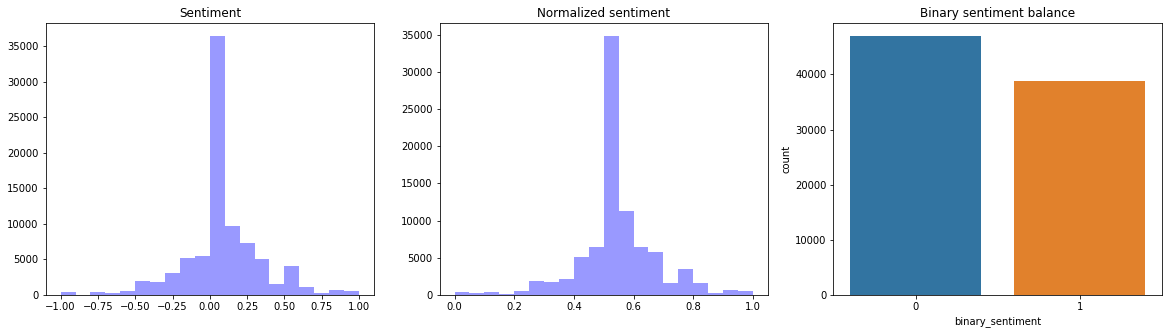

In [ ]:
print('Full dataset')
plot_dataset_dists(df_tweets)

Limited dataset with 22401 examples


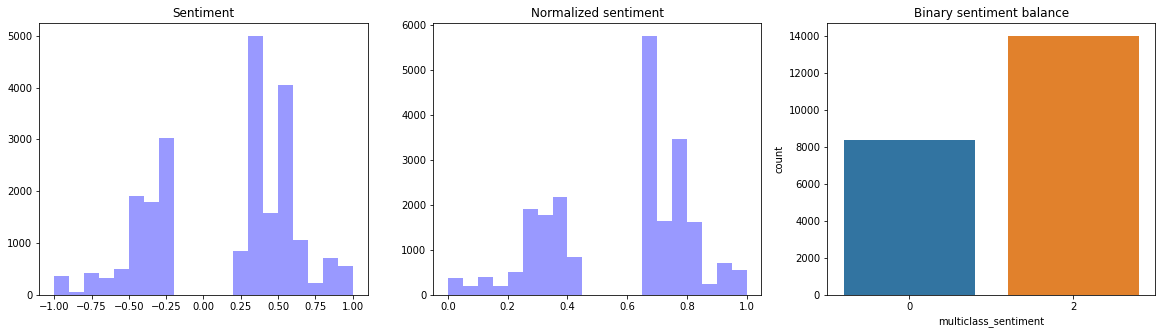

In [ ]:
# LIMIT THE BINARY DATASET TO MORE CONFIDENT REVIEWS
### limit by the normalized sentiment keep values up to 0.3 and from 0.7
UPPER_LOWER_BOUND = 0.65
LOWER_UPPER_BOUND = 0.4
df_tweets_final_binary = df_tweets[(df_tweets['norm_sentiment'] <= LOWER_UPPER_BOUND) | (df_tweets['norm_sentiment'] >= UPPER_LOWER_BOUND)]

print('Limited dataset with {} examples'.format(len(df_tweets_final_binary)))
plot_dataset_dists(df_tweets_final_binary, 'multiclass_sentiment')

In [ ]:
# TRAIN TEST SPLIT
X_train, X_val, X_test, y_train_binary, y_val_binary, y_test_binary = prepare_data(df_tweets_final_binary)

### Torch Dataset pre-paration

In [ ]:
# HYPERPARAMETERS
BATCH_SIZE = 32
EPOCH_NUM = 3
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
!nvidia-smi -L

tokenizer = AutoTokenizer.from_pretrained(model_name)

cuda
GPU 0: Tesla T4 (UUID: GPU-22d626d9-3eeb-9b10-1f2c-01b6e52157b6)


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
# training data
train_dataset = tokenizer_loop(X_train, y_train_binary, tokenizer)
val_dataset = tokenizer_loop(X_val, y_val_binary, tokenizer)
test_dataset = tokenizer_loop(X_test, y_test_binary, tokenizer)

# visualize the set balances
check_label_set_balance([y_train_binary, y_val_binary, y_test_binary])

#Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) #Feel free to experiment with batch sizes
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

TypeError: ignored

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions = True, output_hidden_states=False, num_labels=2)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)

model, res_dict = train_model(model, optimizer, EPOCH_NUM, train_loader, val_loader)

In [ ]:
model.save_pretrained(os.path.join(data_root, 'binary_transformer'))

In [ ]:
## PLOT THE RESULTING TRAIN/VAL PERFORMANCE
train_acc = res_dict['train_acc']
val_acc = res_dict['validation_acc']

plt.plot([i+1 for i in range(len(train_acc))],train_acc, alpha = 0.6, label = 'Training', linestyle='--', marker='o', color = 'blue')
plt.plot([i+1 for i in range(len(train_acc))],val_acc, alpha = 0.6, label = 'Validation', marker='o', color ='red')
plt.xlabel('Epoch')
plt.xticks([i+1 for i in range(len(train_acc))])
plt.ylabel('Accuracy')
plt.title('Accuracy comparison - binary model')
plt.legend()
plt.show()

In [ ]:
## Validate performance on the test set
avg_test_accuracy, avg_test_loss = validation_loop(model, test_loader)

In [ ]:
print('TEST ACCURACY WAS: {}'.format(avg_test_accuracy))

## SEC 2.2: LOADING AND USING PRE-TRAINED BINARY TRANSFORMER

In [ ]:
# HYPERPARAMETERS
BATCH_SIZE = 32
EPOCH_NUM = 5
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
#model_name = 'j-hartmann/sentiment-roberta-large-english-3-classes'
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
!nvidia-smi -L

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
binary_model = AutoModelForSequenceClassification.from_pretrained(os.path.join(data_root, 'binary_transformer')).to(device)

## SEC 3 - TRAINING Model with Neutral Sentiment

In [ ]:
# add multiclass to the dataset
negative_bound = 0.4
positive_bound = 0.6

def multiclass_sentiment(val):
    if val >= positive_bound:
        return 2
    elif val <= negative_bound:
        return 0
    else:
        return 1

df_tweets['multiclass_sentiment'] = df_tweets['norm_sentiment'].apply(multiclass_sentiment)
df_tweets.head(3)

,Unnamed: 0,id,text,sentiment,tweet,norm_sentiment,binary_sentiment,multiclass_sentiment
0,0,1.342326e+18,we wish a grand success for supreme hero for s...,0.278125,We wish a grand success for Supreme Hero @IamS...,0.639062,1,2
1,1,1.342326e+18,sorry to disappoint but I ve not make a dollar...,-0.750000,"Sorry to disappoint, but I’ve not made a dolla...",0.125000,0,0
2,2,1.342326e+18,this be wild the who change the definition of ...,0.237500,This is wild.\nThe WHO changed the definition ...,0.618750,1,2


In [ ]:
# super imbalanced .....
print('Full dataset')
plot_dataset_dists(df_tweets, 'multiclass_sentiment')

In [ ]:
# DOWNSAMPLE THE TWEETS to have balanced dataset

def sample_tweets(sample_size, df):
    sample_size = min(sample_size, len(df))
    return df.sample(n=sample_size)

# sample size
SAMPLE_SIZE = 10000

negative_tweets = sample_tweets(SAMPLE_SIZE, df_tweets[df_tweets['multiclass_sentiment'] == 0])
neutral_tweets = sample_tweets(SAMPLE_SIZE, df_tweets[df_tweets['multiclass_sentiment'] == 1])
positive_tweets = sample_tweets(SAMPLE_SIZE, df_tweets[df_tweets['multiclass_sentiment'] == 2])

print('Lengths are neg: {} neutral: {} pos: {}'.format(len(negative_tweets), len(neutral_tweets), len(positive_tweets)))

# PUT TOGETHER
df_tweets_final_multiclass = pd.concat([negative_tweets, neutral_tweets, positive_tweets])
plot_dataset_dists(df_tweets_final_multiclass, 'multiclass_sentiment')

In [ ]:
X_train, X_val, X_test, y_train_multiclass, y_val_multiclass, y_test_multiclass = prepare_data(df_tweets_final_multiclass, sentiment_type = 'multiclass_sentiment')

In [ ]:
# HYPERPARAMETERS
BATCH_SIZE = 32
EPOCH_NUM = 5
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
#model_name = 'j-hartmann/sentiment-roberta-large-english-3-classes'
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
!nvidia-smi -L

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# training data
train_dataset = tokenizer_loop(X_train, y_train_multiclass, tokenizer)
val_dataset = tokenizer_loop(X_val, y_val_multiclass, tokenizer)
test_dataset = tokenizer_loop(X_test, y_test_multiclass, tokenizer)

# visualize the set balances
check_label_set_balance([y_train_multiclass, y_val_multiclass, y_test_multiclass])

#Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) #Feel free to experiment with batch sizes
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
del df_tweets

In [ ]:
multiclass_model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions = True, output_hidden_states=False, num_labels=3, ignore_mismatched_sizes=True)
multiclass_model = multiclass_model.to(device)

In [ ]:
optimizer = AdamW(multiclass_model.parameters(), lr = 5e-5, eps = 1e-8)

multiclass_model, res_dict = train_model(multiclass_model, optimizer, EPOCH_NUM, train_loader, val_loader)

In [ ]:
multiclass_model.save_pretrained(os.path.join(data_root, 'multiclass_transformer'))

In [ ]:
## PLOT THE RESULTING TRAIN/VAL PERFORMANCE
train_acc = res_dict['train_acc']
val_acc = res_dict['validation_acc']

plt.plot([i+1 for i in range(len(train_acc))],train_acc, alpha = 0.6, label = 'Training', linestyle='--', marker='o', color = 'blue')
plt.plot([i+1 for i in range(len(train_acc))],val_acc, alpha = 0.6, label = 'Validation', marker='o', color ='red')
plt.xlabel('Epoch')
plt.xticks([i+1 for i in range(len(train_acc))])
plt.ylabel('Accuracy')
plt.title('Accuracy comparison - multiclass model')
plt.legend()
plt.show()

In [ ]:
avg_test_accuracy, avg_test_loss = validation_loop(multiclass_model, test_loader)
print('\n TEST ACCURACY WAS: {}'.format(avg_test_accuracy))

In [ ]:
inpt = tokenizer('I hate wearing a mask.', return_tensors='pt')
outpt = multiclass_model(inpt['input_ids'].to(device), attention_mask=inpt['attention_mask'].to(device))
att = outpt['attentions']
outpt.logits

NameError: ignored

In [ ]:
# 6 layers in the model, each layer has 12 attention heads, each head is NxN attention matrix -> CLS + word_len + SEP
print(len(att))
for level in att:
    print(level.shape)

In [ ]:
inpt = torch.zeros(len(torch.round(att[5], decimals=3)[0][0][0])).to(device)
for i in range(12):
    inpt += torch.round(att[5], decimals=5)[0][i][0]

NameError: ignored

In [ ]:
inpt[1:-1]

NameError: ignored

In [ ]:
torch.round(att[5], decimals=3)[0][0][0] + torch.round(att[5], decimals=3)[0][0][0] + torch.round(att[5], decimals=3)[0][0][0]

## SEC 3.1 - Loading pretrained multiclass model

In [ ]:
# add multiclass to the dataset
negative_bound = 0.4
positive_bound = 0.6

def multiclass_sentiment(val):
    if val >= positive_bound:
        return 2
    elif val <= negative_bound:
        return 0
    else:
        return 1

df_tweets['multiclass_sentiment'] = df_tweets['norm_sentiment'].apply(multiclass_sentiment)
df_tweets.head(3)

,Unnamed: 0,id,text,sentiment,tweet,norm_sentiment,binary_sentiment,multiclass_sentiment
0,0,1.342326e+18,we wish a grand success for supreme hero for s...,0.278125,We wish a grand success for Supreme Hero @IamS...,0.639062,1,2
1,1,1.342326e+18,sorry to disappoint but I ve not make a dollar...,-0.750000,"Sorry to disappoint, but I’ve not made a dolla...",0.125000,0,0
2,2,1.342326e+18,this be wild the who change the definition of ...,0.237500,This is wild.\nThe WHO changed the definition ...,0.618750,1,2


In [ ]:
# HYPERPARAMETERS
BATCH_SIZE = 32
EPOCH_NUM = 3
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
!nvidia-smi -L

tokenizer = AutoTokenizer.from_pretrained(model_name)

cuda
GPU 0: Tesla T4 (UUID: GPU-c6a4db7c-8b41-58e7-fd06-74b4f2b4a071)


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
multiclass_model = AutoModelForSequenceClassification.from_pretrained(os.path.join(data_root, 'multiclass_transformer')).to(device)

## Vizualize attention

# New section

In [ ]:
i = 150
print('Label: {}'.format(df_tweets['multiclass_sentiment'][i]))
print('Label: {}'.format(df_tweets['norm_sentiment'][i]))
print('Tweet: {}'.format(df_tweets['tweet'][i]))
df_tweets['text'][i]

Label: 2
Label: 0.8125
Tweet: More horror! https://t.co/AbZkRYTBlE


'more horror '

In [ ]:
i = 450
print('Label: {}'.format(df_tweets['multiclass_sentiment'][i]))
print('Label: {}'.format(df_tweets['norm_sentiment'][i]))
print('Tweet: {}'.format(df_tweets['tweet'][i]))
df_tweets['text'][i]

Label: 2
Label: 0.75
Tweet: I bought a beaver pond. This parcel, adjacent to ours, was being sold under power of sale. For many reasons, there was a very real danger of a buyer destroying it ecologically. So we scraped together money and rescued it. 🦫 🐢 🐍 🐸 https://t.co/im53K1mxNr https://t.co/o3mxTY3Wr2


'I buy a beaver pond this parcel adjacent to ours be be sell under power of sale for many reason there be a very real danger of a buyer destroy it ecologically so we scrape together money and rescue it '

In [ ]:
i = 0
print('Label: {}'.format(df_tweets['multiclass_sentiment'][i]))
print('Label: {}'.format(df_tweets['norm_sentiment'][i]))
print('Tweet: {}'.format(df_tweets['tweet'][i]))
df_tweets['text'][i]

Label: 2
Label: 0.6390625
Tweet: We wish a grand success for Supreme Hero @IamSaiDharamTej, @SVCCofficial for #SoloBrathukeSoBetter release. First Major Theatrical release post lockdown. Watch the movie only in theatres. #CelebrateCinema https://t.co/gjyEFPSOni


'we wish a grand success for supreme hero for solobrathukesobetter release first major theatrical release post lockdown watch the movie only in theatre celebratecinema'

In [ ]:
!pip install bertviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 9.1 MB/s 
     |████████████████████████████████| 1.3 MB 12.8 MB/s 
     |████████████████████████████████| 132 kB 59.2 MB/s 
     |████████████████████████████████| 132 kB 65.8 MB/s 
     |████████████████████████████████| 10.2 MB 49.1 MB/s 
     |████████████████████████████████| 79 kB 9.2 MB/s 
     |████████████████████████████████| 140 kB 65.8 MB/s 
     |████████████████████████████████| 127 kB 65.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
# Load model and retrieve attention weights

from bertviz import head_view, model_view

model = multiclass_model
# sentence_a = "I hate the quarantine and I am depressed that it has lasted so long"
sentence_a = ' '.join(['covid', 'mask', 'quarantine', 'pandemic', 'virus','vaccine','distancing', 'corona', 'trump'])
# sentence_a = "I think covid is great for the society."
# sentence_a = "I am angry"
# sentence_a = "we wish a grand success for supreme hero for solobrathukesobetter release first major theatrical release post lockdown watch the movie only in theatre celebratecinema"

inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt')

input_ids = inputs['input_ids'].to(device)
att_mask = inputs['attention_mask'].to(device)

out = model(input_ids, attention_mask=att_mask)
attention = out['attentions']
tokens = tokenizer.convert_ids_to_tokens(input_ids[0]) 

m = nn.Softmax(dim=1)
torch.round(m(out['logits']), decimals=3)

tensor([[0.0000, 0.9990, 0.0000]], device='cuda:0', grad_fn=<RoundBackward1>)

In [ ]:
print(len(attention))
print(attention[0].shape)

6
torch.Size([1, 12, 18, 18])


In [ ]:
attention[0][0,0,0].shape

torch.Size([18])

In [ ]:
inputs

{'input_ids': tensor([[  101,  2522, 17258,  7308, 24209, 20486, 10196,  6090,  3207,  7712,
          7865, 17404,  4487, 12693,  6129, 21887,  8398,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
tokens

['[CLS]',
 'co',
 '##vid',
 'mask',
 'qu',
 '##aran',
 '##tine',
 'pan',
 '##de',
 '##mic',
 'virus',
 'vaccine',
 'di',
 '##stan',
 '##cing',
 'corona',
 'trump',
 '[SEP]']

##Preparation: Merging attention heads for split up word tokens
For example, attn("distancing") -> attn("di") + attn("stan") + attn("cing")

In [ ]:
def merge_tokens(attention, tokens):
  """
  attention is a (n-layers = 6)-tuple, where each element of the tuple
  is a [1 x 12 x n_tokens x n_tokens]

  returns the merged attentions: (n-layers=6)-tuple, where each element of the
  tuple is a [1 x 12 x n_merged_tokens x n_merged_tokens]
  """
  nlayers = len(attention)
  batch_size, head_size, n_tokens, n_tokens = attention[0].shape

  merged_tokens = []
  # attentions only for [cls]
  merged_attentions = [torch.permute(torch.zeros((batch_size, head_size, 1, n_tokens)), (2, 3, 0, 1)).to(device) for i in range(nlayers)] 

  wordi = -1
  for i in range(len(tokens)):
    if (tokens[i].startswith("##")):
      merged_tokens[wordi] += tokens[i][2:]
    else:
      wordi += 1
      merged_tokens.append(tokens[i])

    for li in range(nlayers):
      attention_layer = attention[li]
      if (tokens[i].startswith("##")):
        merged_attentions[li][0:1] += torch.permute(attention_layer[:, :, 0:1, i:i+1], (2, 3, 0, 1))
      else:
        merged_attentions[li][0:1] = torch.permute(attention_layer[:, :, 0:1, i:i+1], (2, 3, 0, 1))

  merged_attentions = [torch.permute(merged_attentions[i], (2, 3, 0, 1))[:, :, :, :wordi+1] for i in range(nlayers)]
  return merged_attentions, merged_tokens

In [ ]:
merged_attentions, merged_tokens = merge_tokens(attention, tokens)

In [ ]:
merged_tokens

['[CLS]',
 'covid',
 'mask',
 'quarantine',
 'pandemic',
 'virus',
 'vaccine',
 'distancing',
 'corona',
 'trump',
 '[SEP]']

In [ ]:
print("len(merged_attentions):", len(merged_attentions))
print("merged attention layer shape: ", merged_attentions[0].shape)

len(merged_attentions): 6
merged attention layer shape:  torch.Size([1, 12, 1, 11])


batch size x attention heads x token x token 

In [ ]:
def average_across_all(attention, token_index = 0): 
    """
    returns a tensor of averaged attention weights across each (batch size x 12 heads x 6 layers)  
    """
    attn_heads = torch.cat(attention,dim=1)
    token_attn_weights = attn_heads[:,:,token_index,:]
    return torch.mean(token_attn_weights,dim=1)

In [ ]:
#sanity check
attn = [torch.ones((32,12,6,6))*i for i in range(4)]
avg_attn = average_across_all(attn,0)
assert torch.all(torch.eq(avg_attn, 1.5))

attn = [torch.ones((32,12,6,6))*0 for i in range(4)]
avg_attn = average_across_all(attn,0)
assert torch.all(torch.eq(avg_attn, 0))

In [ ]:
def average_across_heads(attention, token_index = 0): 
    """
    returns a (batch size x num_layers x num_tokens) tensor of attention weights, averaged across all heads per layer  
    """
    attn_heads = torch.stack(attention,dim=1)
    attn_heads = torch.mean(attn_heads, dim = 2)
    return attn_heads[:,:,token_index,:]

In [ ]:
bob = [torch.zeros((32, 12, 7, 7)) for i in range(6)]
attn_heads= torch.stack(bob,dim=1)
attn_heads= torch.mean(attn_heads, dim = 2)
attn_heads[:,:,0,:].shape

torch.Size([32, 6, 7])

In [ ]:
#sanity check, batch size = 1
attn = [torch.ones((1,12,6,6))*i for i in range(6)]
avg_attn = average_across_heads(attn,0)
for layer in range(6):
    assert torch.all(torch.eq(avg_attn[0,layer],layer))

# batch size != 0 
attn = [torch.ones((2,12,6,6))*i for i in range(6)]
avg_attn = average_across_heads(attn,0)
for layer in range(6):
    for batch in range(2): 
        assert torch.all(torch.eq(avg_attn[batch,layer],layer))

In [ ]:
attention[0].squeeze()[0,0,:] #first layer, first attention head

tensor([0.1941, 0.0620, 0.0887, 0.0965, 0.5587], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
# layer 4 (actually 5) seems to detect the negative/positive word which causes the classification
# Note that the model cant handle negation
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [ ]:
sentence_a = "#arsenal is super strong and great team."
inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt')

input_ids = inputs['input_ids'].to(device)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0]) 

tokens

['[CLS]',
 '#',
 'arsenal',
 'is',
 'super',
 'strong',
 'and',
 'great',
 'team',
 '.',
 '[SEP]']